In [ ]:
# Date: 9.8.2023
# Author: Antti Kiviaho
#
# This notebook handles clustered Visium data with the goal of
# analyzing ligand-receptor interactions between
# 1. Joint leiden clusters (spatial proximity + gene expression)
# 2. A cluster of interest and it's immediate surroundings

In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from scripts.utils import load_from_pickle, get_sample_ids, save_to_pickle, get_treatment_info
import matplotlib as mpl

import seaborn as sns
sns.set_theme()

sc.set_figure_params(figsize=(8,8))

import warnings
warnings.filterwarnings("ignore")


# import matplotlib library
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests



In [2]:

# Define functions
def get_annotation_proximity_spots(dat, cluster_of_interest, interaction_cluster, added_key='proximity_analysis'):

    ''' This function is used when clusters have been annotated as one of three:
        1. tumor
        2. normal
        3. stroma
    and must be saved in 'annotation' observation column
    See above for the procedure of creating these annotations.'''

    # Create an observation column for spatial segmentation
    dat.obs[added_key] = 'background'
    distance_mat = dat.obsp['spatial_distances'].todense()

    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs['annotation'][idx]

        if cl == cluster_of_interest:

            first_nhbor_idxs = np.where(distance_mat[:,idx]==1.0)[0] # Get first-term neighbor indices

            try:
                # If try fails, there are no matching clusters as keys in value_counts
                n_cl_neighbors = dat[first_nhbor_idxs].obs['annotation'].value_counts()[cl] # find first-term neighbor cluster annotations POSSIBLE ERROR IF CL NOT IN DICT

                # Added this clause to control that only those with 'close' interactions with the interaction cluster are included. 
                all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0]

                # Downgraded the number of required first neighbors to two
                if (n_cl_neighbors >= 2) & (sum(dat.obs['annotation'][all_nhbor_indices] == interaction_cluster) >= 3):
                    dat.obs.at[obs_name,added_key] = cl

            except:
                continue

    # Make a second loop to make sure the final cluster-of-interest annotations
    # are what's used to define proximal spots
    for idx, obs_name in enumerate(dat.obs_names):
        cl = dat.obs[added_key][idx]

        if cl == cluster_of_interest:
            
            all_nhbor_indices = np.where(distance_mat[:, idx] != 0)[0] 

            # Get the indices where neighboring spots are not the interest cluster 
            indices = np.where((dat.obs[added_key][all_nhbor_indices] != cl) & (dat.obs['annotation'][all_nhbor_indices] == interaction_cluster))[0]

            # Update the 'proximity_analysis' column for the specific indices
            dat.obs.loc[dat.obs_names[all_nhbor_indices[indices]], added_key] = 'proximal_' + interaction_cluster

    # Modify the colors to maintain the original cluster color
    dat.obs[added_key] = dat.obs[added_key].astype('category')

    return(dat)

def most_common_interactions(dct):
    tuple_lst = []
    for key in dct.keys():
        [tuple_lst.append(tup) for tup in dct[key]]
    res = pd.Series(tuple_lst).value_counts()
    return(res)

def merge_dicts(dict1, dict2):
    merged_dict = {}

    for key, value in dict1.items():
        if key in dict2:
            merged_dict[key] = [value, dict2[key], value - dict2[key]]
        else:
            merged_dict[key] = [value, 0, value]

    for key, value in dict2.items():
        if key not in merged_dict:
            merged_dict[key] = [0, value, 0 - value]

    return merged_dict


In [3]:
adata_slides = load_from_pickle('./data/clustered_visium_data.pickle')
samples = get_sample_ids()

In [4]:
# Instead of manually selecting interactions, make a script that automatically finds the highest mean cell type
# and if it is tumor, annotate it as such (or fibroblast, luminal, basal etc.)
cell_mapping_dat = sc.read_h5ad('c2l_mapping_as_anndata_20230721.h5ad')


# Normalize inferred cell counts to cell-type proportions

arr = cell_mapping_dat.X.copy()
# Calculate the row sum
row_sum = np.sum(arr, axis=1)

# Calculate the scaling factor for each row
scaling_factor = 100 / row_sum

# Multiply each row with its respective scaling factor
scaled_arr = np.multiply(arr.T, scaling_factor).T

cell_mapping_dat.X = scaled_arr.copy()


In [5]:
representative_celltypes = {}
n_max_cell_comb= 2

# Initialize the dict in case top number of celltypes does not satisfy the p-value threshold
for c in cell_mapping_dat.obs['joint_leiden_clusters'].cat.categories:
    representative_celltypes[c] = [None,np.nan]

for cluster in cell_mapping_dat.obs['joint_leiden_clusters'].cat.categories:
    subset = cell_mapping_dat[cell_mapping_dat.obs['joint_leiden_clusters'] == cluster].copy()

    for split_idx in (np.arange(n_max_cell_comb)+1)[::-1]:
        idxs = np.argsort(np.round(np.mean(subset.X,axis=0)))[::-1].tolist()
        top_5 = list(subset.var_names[idxs])[:5]
        top_ctypes = list(subset.var_names[idxs])[:split_idx]
        rest_ctypes = list(subset.var_names[idxs])[split_idx:]

        #sc.pl.violin(subset,keys=top_5,jitter=False,rotation=30,inner='box',palette='Set2')

        pval = ttest_rel(
            np.sum(subset[:,top_ctypes].X.copy(),axis=1).ravel(),
            np.sum(subset[:,rest_ctypes].X.copy(),axis=1).ravel(),alternative='greater')[1]

        if pval < 0.05:
            if split_idx > 1:
                representative_celltypes[cluster] = ['_'.join(top_ctypes),pval]
            else:
                representative_celltypes[cluster] = [top_ctypes[0],pval]


res_df = pd.DataFrame(representative_celltypes,index=['cell-type combination','p-value']).T


# Get the p-values from res_df in a separate variable
p_values = res_df['p-value']

# Perform the Benjamini-Hochberg correction
corrected_values = multipletests(p_values, method='fdr_bh')

# Update the 'p-value' column in res_df with the corrected values
res_df['corr_p-value'] = corrected_values[1]

res_df = res_df[res_df['corr_p-value']<0.05]

In [6]:
# Annotate clusters to an uniform format
res_df[(res_df == 'myofibroblasts_inflammatory fibroblasts') | (res_df == 'inflammatory fibroblasts_myofibroblasts') | (res_df == 'myofibroblasts') | (res_df== 'inflammatory fibroblasts') ] = 'stroma'
res_df[(res_df == 'ERG tumor epithelium') | (res_df == 'luminal epithelium_ERG tumor epithelium') | (res_df == 'ERG tumor epithelium_luminal epithelium') | (res_df == 'ERG tumor epithelium_inflammatory fibroblasts') | (res_df == 'ERG tumor epithelium_myofibroblasts')] = 'tumor'
res_df[(res_df == 'luminal epithelium') | (res_df == 'luminal epithelium_inflammatory fibroblasts') | (res_df == 'luminal epithelium_normal basal epithelium') | (res_df == 'luminal epithelium_myofibroblasts')] = 'normal'

# Drop rows with uniqe cell type combinations
res_df = res_df[~res_df['cell-type combination'].isin(list(res_df['cell-type combination'].value_counts().index[res_df['cell-type combination'].value_counts() <2]))]

res_df['cell-type combination'].value_counts()

stroma    63
tumor     62
normal    39
Name: cell-type combination, dtype: int64

In [7]:
# Copy the annotation column into each member of the adata_slides object
cluster_annotation_dict = res_df['cell-type combination'].to_dict()

for sample in samples:
    dat = adata_slides[sample].obs.copy()
    dat['sample_cluster'] = dat['sample_id'].astype(str) + '_' + dat['joint_leiden_clusters'].astype(str)
    adata_slides[sample].obs['annotation'] = dat['sample_cluster'].map(cluster_annotation_dict)


In [8]:
colors_dict = {
    'tumor_normal':['#919191','#74b572','#db1616'],
    'tumor_stroma':['#919191','#f7f774','#db1616'],
    'normal_tumor':['#919191','#74b572','#db1616'],
    'normal_stroma':['#919191','#74b572','#f7f774'],
    'stroma_normal':['#919191','#74b572','#f7f774'],
    'stroma_tumor':['#919191','#db1616','#f7f774']
}

In [15]:
source = 'tumor'
target = 'normal'
cols = colors_dict['tumor_normal']
interaction_dict = {}

for sample in samples:

    slide = adata_slides[sample].copy()

    if (slide.obs['annotation'].str.contains(source).any()) & (slide.obs['annotation'].str.contains(target).any()):
        # Using three rings you get 6 immediate neigbors, 12 second neigbors and 18 third neighbors
        sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=4)

        slide = get_annotation_proximity_spots(slide, source, target)
    
        sq.gr.ligrec(
            slide,
            n_perms=100,
            cluster_key="proximity_analysis",
            show_progress_bar = False
        )

        proximal_spots = 'proximal_' + target

        pvals = slide.uns['proximity_analysis_ligrec']['pvalues'][source][proximal_spots]
        means = slide.uns['proximity_analysis_ligrec']['means'][source][proximal_spots]
        tuple_array = pd.DataFrame(means[pvals<0.01][means>1]).index.values

        interaction_dict[sample] = tuple_array

        ## Plotting ##
        slide.uns['proximity_analysis_colors'] = cols

        # set figure axis size and dpi
        fig, ax = plt.subplots(figsize=(5, 5), dpi=120)

        # create spatial plot
        sc.pl.spatial(slide,color='proximity_analysis',size=1.3,alpha=0.8, ax = ax, show= False, title= sample)
        plt.tight_layout()

        # create filename with sample name
        filename = 'plots/receptor_ligand_interaction_analysis/' + sample + '_'+ source +'_to_'+ target +'_clusters_communication.pdf'

        # create output folder if it doesn't exist
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))

        # save plot to pdf with filename
        with PdfPages(filename) as pdf:
            pdf.savefig(fig)
            plt.clf()

save_to_pickle(interaction_dict,'./data/'+source+'_to_'+target+'_ligand_receptor_proximity_interactions.pickle')


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

## Performing treament-status based differential expression analysis

In [288]:
treatment_info = get_treatment_info()

source = 'tumor'
target = 'normal'
concat_list = []

ligand_receptor_dict = load_from_pickle('data/'+source+'_to_'+target+'_ligand_receptor_proximity_interactions.pickle')

treated = {}
untreated = {}

for s in ligand_receptor_dict.keys():

    if (treatment_info[s] == 'goserelin') | (treatment_info[s] == 'bicalutamide'):
        treated[s] = ligand_receptor_dict[s]

    if (treatment_info[s] == 'untreated'):
        untreated[s] = ligand_receptor_dict[s]
        

for sample in samples:

    slide = adata_slides[sample].copy()

    if (slide.obs['annotation'].str.contains(source).any()) & (slide.obs['annotation'].str.contains(target).any()):
        # Using three rings you get 6 immediate neigbors, 12 second neigbors and 18 third neighbors
        sq.gr.spatial_neighbors(slide,n_neighs=6,n_rings=4)

        slide = get_annotation_proximity_spots(slide, source, target)

        concat_list.append(slide)

dat_concat = ad.concat(concat_list)

In [289]:
treated_most_common = most_common_interactions(treated)
untreated_most_common = most_common_interactions(untreated)
merged_dict = merge_dicts(untreated_most_common,treated_most_common)

df = pd.DataFrame(merged_dict,index=[
    'untreated '+ '('+str(len(untreated))+')',
    'treated  '+ '('+str(len(treated))+')',
    'diff']).T.sort_values('diff',ascending=False)

ligands = np.array([tup[0] for tup in list(df.index)])
_, idx = np.unique(ligands, return_index=True)
ligands = ligands[np.sort(idx)].tolist()

receptors = np.array([tup[1] for tup in list(df.index)])
_, idx = np.unique(receptors, return_index=True)
receptors = receptors[np.sort(idx)].tolist()


In [290]:
df[(df['diff']>=3) | (df['diff']<=-2)]

untreated (6)  treated  (2)  diff
GDF15  ERBB3               5             0     5
CMTM3  KLK3                6             2     4
GDF15  ERBB2               4             0     4
       TGFBR2              3             0     3
CALR   P4HB                5             2     3
       TAP2                4             1     3
       LRP1                3             0     3
GDF15  EGFR                3             0     3
       PTK2                3             0     3
MDK    NCL                 0             2    -2
HLA-B  KLRD1               0             2    -2
LGALS3 ANXA2               0             2    -2
MDK    SDC1                0             2    -2
HLA-B  CD8B                0             2    -2
HSPA8  MAPK9               0             2    -2
VEGFA  ERBB2               0             2    -2
       NFE2L2              0             2    -2
HLA-B  CD3G                0             2    -2

In [291]:
treatment_info = get_treatment_info()

dat_concat.obs['treatment_status'] = dat_concat.obs['sample_id'].map(treatment_info).astype('category')
dat_concat = dat_concat[dat_concat.obs['proximity_analysis'] != 'background']
dat_concat = dat_concat[(dat_concat.obs['treatment_status'].isin(['untreated','bicalutamide']))]

# For tumor
tumor_subset = dat_concat[dat_concat.obs['proximity_analysis'] == 'tumor']
sc.tl.rank_genes_groups(tumor_subset,groupby='treatment_status')

tumor_subset_res_df = sc.get.rank_genes_groups_df(tumor_subset,group='untreated')
tumor_subset_res_df = tumor_subset_res_df[(tumor_subset_res_df['logfoldchanges']>=1) &(tumor_subset_res_df['pvals_adj']<0.05)].sort_values('pvals_adj',ascending=True).reset_index(drop=True)

# Remove the lfc>1 condition
# 
# For stroma
target_subset = dat_concat[dat_concat.obs['proximity_analysis'] == 'proximal_'+target]
sc.tl.rank_genes_groups(target_subset,groupby='treatment_status')

target_subset_res_df = sc.get.rank_genes_groups_df(target_subset,group='untreated')
target_subset_res_df = target_subset_res_df[(target_subset_res_df['logfoldchanges']>=1) & (target_subset_res_df['pvals_adj']<0.05)].sort_values('pvals_adj',ascending=True).reset_index(drop=True)
# Remove the lfc>1 condition
#


In [292]:
tumor_de_res = tumor_subset_res_df[tumor_subset_res_df['names'].isin(ligands)][:10]
tumor_de_res

,names,scores,logfoldchanges,pvals,pvals_adj
6,GDF15,26.265862,1.999140,5.177032e-126,7.744323e-124
12,ALDH1A3,21.899084,1.276422,3.913762e-91,3.682136e-89
16,SPON2,20.418461,1.678994,1.163825e-83,9.891851e-82
17,TFF3,19.925171,1.576049,1.137101e-79,8.952579e-78
38,LRIG1,15.615120,1.221264,5.375101e-51,2.466446e-49
150,ADM,6.099532,1.187929,1.322846e-09,8.790964e-09
243,EGF,3.458113,1.210616,5.569990e-04,1.526873e-03


In [293]:
target_subset_res_df[target_subset_res_df['names'].isin(receptors)][:10]

,names,scores,logfoldchanges,pvals,pvals_adj
46,ADRB1,9.275340,1.098906,5.406398e-20,5.847744e-19
75,RET,6.301174,1.395112,3.645534e-10,1.680023e-09


In [294]:
# For untreated
untreated_subset = dat_concat[dat_concat.obs['treatment_status'] == 'untreated']
sc.tl.rank_genes_groups(untreated_subset,groupby='proximity_analysis')

untreated_subset_res_df = sc.get.rank_genes_groups_df(untreated_subset,group='tumor')
untreated_subset_res_df = untreated_subset_res_df[(target_subset_res_df['logfoldchanges']>=1) &(untreated_subset_res_df['pvals_adj']<0.05)].sort_values('pvals_adj',ascending=True).reset_index(drop=True)

# For treated
treated_subset = dat_concat[dat_concat.obs['treatment_status'] == 'bicalutamide']
sc.tl.rank_genes_groups(treated_subset,groupby='proximity_analysis')

treated_subset_res_df = sc.get.rank_genes_groups_df(treated_subset,group='tumor')
treated_subset_res_df = treated_subset_res_df[(target_subset_res_df['logfoldchanges']>=1) &(treated_subset_res_df['pvals_adj']<0.05)].sort_values('pvals_adj',ascending=True).reset_index(drop=True)
# Remove the lfc>1 condition
#


In [295]:
genes_of_interest_df = untreated_subset_res_df[~(untreated_subset_res_df['names'].isin(treated_subset_res_df['names']))][:10]
genes_of_interest_df

,names,scores,logfoldchanges,pvals,pvals_adj
8,TPT1,20.795767,0.488898,4.444382e-89,5.540292e-86
42,ODC1,17.175632,0.967804,1.011424e-62,2.801832e-60
52,PDLIM3,16.726690,1.079383,1.119342e-59,2.576036e-57
53,TRGC1,16.466509,0.883722,2.958039e-58,6.604375e-56
56,AGR2,15.940055,1.009178,7.006121e-55,1.416278e-52
57,TMEM178A,16.045340,1.618261,1.197280e-54,2.388015e-52
68,SERHL2,15.035718,1.153568,9.153812e-49,1.538560e-46
69,FLI1,15.138084,2.333115,1.298183e-48,2.157725e-46
72,MYO6,14.582057,0.948284,2.786766e-46,4.434812e-44
83,AP001816.1,13.855103,0.911142,4.376042e-42,6.005616e-40


In [296]:
genes_of_interest = genes_of_interest_df['names'].reset_index(drop=True)
df = pd.DataFrame(dat_concat[:,genes_of_interest].layers['counts'].toarray(),columns=genes_of_interest,index = dat_concat.obs_names)
df = pd.merge(df,dat_concat.obs[['proximity_analysis','treatment_status']],left_index=True,right_index=True)


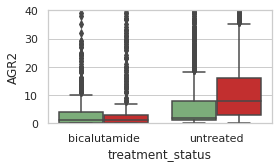

In [320]:
g = genes_of_interest[4]
# Set the figure size and theme
sns.set(rc={'figure.figsize':(4,2)})
sns.set_theme(style="whitegrid")

# Define custom color palette and color codes
custom_palette = ['#db1616','#74b572','#f7f774']
color_codes_wanted = ['tumor', 'normal', 'stroma']

# Define a lambda function to retrieve color from custom palette based on color codes
c = lambda x: custom_palette[color_codes_wanted.index(x)]

# Create the boxplot using seaborn
sns.boxplot(data=df, x="treatment_status", y=g, hue="proximity_analysis", palette = sns.color_palette([c('normal'),c('tumor')],2))

# Set the y-axis limits
plt.ylim(0,40)#np.quantile(df[g],0.95)

# Remove the legend frame
plt.legend([],[], frameon=False)

# Set the DPI to 200
plt.savefig('./plots/output_'+g+'.pdf')
plt.show()


## Loading and inspecting ligand-receptor binding results

In [50]:
source = 'tumor'
target = 'stroma'

ligand_receptor_dict = load_from_pickle('data/'+source+'_to_'+target+'_ligand_receptor_proximity_interactions.pickle')

interface_interaction = most_common_interactions(ligand_receptor_dict)
df = pd.DataFrame(interface_interaction,columns=[
    source +' --> ' + target + ' ('+str(len(ligand_receptor_dict))+')'])
df[:30]


,tumor --> stroma (11)
"(CD99, CD81)",9
"(PPIA, MAPK3)",9
"(PPIA, CXCR4)",9
"(CALR, LRP1)",9
"(MIF, CD74)",8
"(CALR, ITGAV)",8
"(TNF, MYLK)",8
"(KIT, CD81)",7
"(MDK, ITGB1)",7
"(HLA-C, CD81)",7


In [51]:
source = 'tumor'
target = 'normal'

ligand_receptor_dict = load_from_pickle('data/'+source+'_to_'+target+'_ligand_receptor_proximity_interactions.pickle')

interface_interaction = most_common_interactions(ligand_receptor_dict)
df = pd.DataFrame(interface_interaction,columns=[
    source +' --> ' + target + ' ('+str(len(ligand_receptor_dict))+')'])
df[:30]


,tumor --> normal (8)
"(CMTM3, KLK3)",8
"(CALR, P4HB)",7
"(CALR, PDIA3)",6
"(MDK, TSPAN1)",6
"(CALR, AR)",6
"(PPIA, MAPK3)",6
"(GDF15, ERBB3)",5
"(PPIA, CXCR4)",5
"(TGFB1, P4HB)",5
"(AZGP1, ITGAV)",5


In [ ]:
import numpy as np
from scipy.stats import fisher_exact

contingency_table = np.array([[5, 2], [3, 9]])
print(contingency_table)
odds_ratio, p_value = fisher_exact(contingency_table)

print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)
